# App Sample Data Generator

## Notebook for generating some sample data to be used by the app.

This notebook was used to generate sample data for the app. We basically read off the data from `vis/data` folder and save in `json` format in a separate directory tree. The data might include all these sample PFs.

- DTLZ2 ($m$-Sphere) Problem
- DEBMDK (Knee) Problem
- CDEBMDK (Constrained Knee) Problem
- C0-DTLZ2 (A split $m$-sphere with a small isolated cluster at $f_m$-axis)
- C2-DTLZ2 Problem
- DTLZ8 Problem (A 3-dimensional line and an $m$-dimensional hypersurface)
- GAA Problem (A 10-objective and 18-constraint general aviation design problem)

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
sys.path.append('../../')
import matplotlib.colors as mc
from vis.plotting.utils import resize_by_tradeoff, color_by_dist, color_by_cv, enhance_color

def load_props(path):
    r"""
    Load CV, Mu, Ik and S from path.
    """
    CV = None
    cvpathf = os.path.join(path, "datacv.csv")
    if os.path.exists(cvpathf):
        CV = np.loadtxt(cvpathf)

    # load the Mu values
    Mu = None
    mupathf = os.path.join(path, "mu.csv")
    if os.path.exists(mupathf):
        Mu = np.loadtxt(mupathf)

    # load the knee indices
    Ik = None
    kpathf = os.path.join(path, "muid.csv")
    if os.path.exists(kpathf):
        Ik = np.loadtxt(kpathf, dtype=int)
    
    return CV, Mu, Ik

def decide_size_color(CV, Mu, Ik):
    r"""
    Decide point-size and color from `CV`, `Mu` and `Ik`
    """
    # decide point-size
    S = 1
    if Mu is not None and Ik is not None:
        S = resize_by_tradeoff(Mu, k=Ik)

    # decide colors
    # C = default_color(F.shape[0], alpha=0.5)
    M = np.mean(F, axis=0)
    Cd, D = color_by_dist(F, M, alpha=0.25, factor=1.5)
    
    # if CV is available, use CV to color
    Ccv = None
    if CV is not None:
        Ccv = color_by_cv(CV)

    # enhance knee points
    if Ik is not None:
        Cd = enhance_color(Cd, Ik)
        if Ccv is not None:
            Ccv = enhance_color(Ccv, Ik)
            
    return S, Cd, Ccv, D

def to_hex(C):
    H = np.zeros(C.shape[0], dtype=object)
    for i in range(C.shape[0]):
        H[i] = mc.to_hex(C[i])
    H = np.reshape(H, (H.shape[0],))
    return H

def jsonize(X):
    if len(X.shape) > 1 and X.shape[1] == 1:
        X = np.reshape(X, (X.shape[0],))
    item = X[0,0] if len(X.shape) > 1 else X[0]
    if type(item) is str or type(item) is object:
        fmt = "\"{0:s}\""
    elif type(item) is int or type(item) is np.int64:
        fmt = "{0:d}"
    else:
        fmt = "{0:.4e}"
    s = '[' + ','.join([('[' + ','.join([fmt.format(x) for x in v]) + ']') if type(v) is np.ndarray \
                        else fmt.format(v) for v in X]) + ']'
    return s

def generate_index_file(pf=None, F=None, An=None, path=None, has_cv=True):
    s = """
        var data = {{
            // data name
            name: \"{0:s}\",
            // number of points
            n: {1:d},
            // dimension
            m: {2:d},
            // f-values
            f: require(\"./dataf.json\"),
            // lower bounds
            lb: {3:s},
            // upper bounds
            ub: {4:s},
            // knee indices
            kid: require(\"./muid.json\"),
            // indices except knees
            pid: require(\"./pid.json\"),
            // tradeoff values
            mu: require(\"./mu.json\"),
            // centroid distances
            cd: require(\"./cdist.json\"),
            // color by centroid
            clcd: require(\"./color-centroid.json\"),
            // cv values
            cv: {5:s},
            // color by cv
            clcv: {6:s},
            // palette coordinates with radviz
            rvp: require(\"./palette-radviz.json\"),
            // palette coordinates with star
            strp: require(\"./palette-star.json\"),
            // palette anchor coordinates
            apv: {7:s},
            // radviz coordinates
            rv: require(\"./radviz.json\"),
            // star coordinates
            str: require(\"./star.json\"),
            // polar anchor coordinates
            ap: {8:s}
        }};
        
        export default data;
    """
    
    pf = '_'.join(pf.split('-'))
    var = "{0:s}_{1:s}".format(pf,dim)
    name = "{:s}".format(pf.upper())
    cv = "require(\"./datacv.json\")" if has_cv else "Array({0:d}).fill(0.0)".format(F.shape[0])
    clcv = "require(\"./color-cv.json\")" if has_cv else "Array({0:d}).fill(\"grey\")".format(F.shape[0])
    lb = "[" + ", ".join(["{0:.4e}".format(v) for v in F.min(axis=0)]) + "]"
    ub = "[" + ", ".join(["{0:.4e}".format(v) for v in F.max(axis=0)]) + "]"
    apv,ap = An
    
    # print('var =', var)
    print('name =', name)
    print('n =', F.shape[0]) 
    print('m =', F.shape[1]) 
    print('lb =', lb) 
    print('ub =', ub) 
    print('cv =', cv) 
    print('clcv =', clcv) 
    print('apv =', apv)
    print('ap =', ap)
    
    s = s.format(name, F.shape[0], F.shape[1], lb, ub, cv, clcv, apv, ap)
    print(s)
    
    fp = open(path, 'w')
    fp.write(s)
    fp.close()
    
def dump_files(destpath, PFD=None, CDD=None, CVD=None, PRV=None, PSV=None, FRV=None, FSV=None):
    if (PFD is not None and len(PFD) == 3):
        F,Mu,Ik = PFD
        if (F is not None):
            fp = open(os.path.join(destpath, "dataf.json"), 'w')
            fp.write(jsonize(F))
            fp.close()
        if (Mu is not None):
            fp = open(os.path.join(destpath, "mu.json"), 'w')
            fp.write(jsonize(Mu))
            fp.close()
        if (Ik is not None):
            fp = open(os.path.join(destpath, "muid.json"), 'w')
            fp.write(jsonize(Ik))
            fp.close() 
            
            I = np.zeros(F.shape[0]).astype(bool)
            I[Ik] = True
            Ip = np.arange(0,F.shape[0],1).astype(int)[~I]
            
            fp = open(os.path.join(destpath, "pid.json"), 'w')
            fp.write(jsonize(Ip))
            fp.close()
    
    if (CDD is not None and len(CDD) == 2):
        D,Cd = CDD
        if (D is not None):
            fp = open(os.path.join(destpath, "cdist.json"), 'w')
            fp.write(jsonize(D))
            fp.close()  
        if (Cd is not None):
            fp = open(os.path.join(destpath, "color-centroid.json"), 'w')
            fp.write(jsonize(to_hex(Cd)))
            fp.close()
    
    if (CVD is not None and len(CVD) == 2):
        CV,Ccv = CVD
        if(CV is not None):
            fp = open(os.path.join(destpath, "datacv.json"), 'w')
            fp.write(jsonize(CV))
            fp.close()
        if (Ccv is not None):
            fp = open(os.path.join(destpath, "color-cv.json"), 'w')
            fp.write(jsonize(to_hex(Ccv)))
            fp.close()

    apv = None
    if(PRV is not None and len(PRV) == 4):
        Prv,K,_,Z = PRV
        if (Prv is not None):
            fp = open(os.path.join(destpath, "palette-radviz.json"), 'w')
            fp.write(jsonize(Prv))
            fp.close()
        apv = "[" + ",".join([jsonize(\
                                       np.hstack((np.vstack((K, [K[0]])), \
                                                  np.reshape(\
                                                             np.repeat(z, K.shape[0]+1), \
                                                             (K.shape[0]+1,1))))) for z in Z]) + "]"
    if(PSV is not None and len(PSV) == 4):
        Psv,_,_,_ = PSV
        if (Psv is not None):
            fp = open(os.path.join(destpath, "palette-star.json"), 'w')
            fp.write(jsonize(Psv))
            fp.close()
            
    ap = None
    if(FRV is not None and len(FRV) == 3):
        Frv,K,_ = FRV
        if (Frv is not None):
            fp = open(os.path.join(destpath, "radviz.json"), 'w')
            fp.write(jsonize(Frv))
            fp.close()
        ap = jsonize(np.vstack((K,K[0])))
            
    if(FSV is not None and len(FSV) == 3):
        Fsv,_,_ = FSV
        if (Fsv is not None):
            fp = open(os.path.join(destpath, "star.json"), 'w')
            fp.write(jsonize(Fsv))
            fp.close()
            
    generate_index_file(pf=pf, F=F, An=[apv, ap], \
                        path=os.path.join(destpath, "index.js"), \
                        has_cv=(CV is not None))

../../data/dtlz2-nbi/3d/dataf.csv (990, 3) ['..', '..', 'data', 'dtlz2-nbi', '3d'] dtlz2-nbi
Loading depth contours from ../../data/dtlz2-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz2-nbi/3d/depth-cont-cvhull.csv.
name = DTLZ2_NBI
n = 990
m = 3
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = Array(990).fill(0.0)
clcv = Array(990).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[-5.0000e-01,8.6603e-01,1.0000e+00],[-5.0000e-01,-8.6603e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[-5.0000e-01,8.6603e-01,8.0000e-01],[-5.0000e-01,-8.6603e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[-5.0000e-01,8.6603e-01,6.0000e-01],[-5.0000e-01,-8.6603e-01,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.0000e+00,0.0000e+00,4.0000e-01],[-5.0000e-01,8.6603e-01,4.0000e-01],[-5.0000e-01,-8.6603e-01,4.0000e-01],[1.0000e+00,0.0000e+00,4.0000e-01]

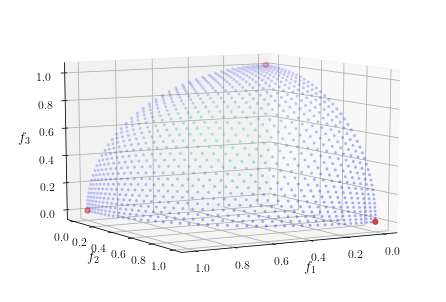

../../data/dtlz2-nbi/4d/dataf.csv (1771, 4) ['..', '..', 'data', 'dtlz2-nbi', '4d'] dtlz2-nbi
Loading depth contours from ../../data/dtlz2-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz2-nbi/4d/depth-cont-cvhull.csv.
name = DTLZ2_NBI
n = 1771
m = 4
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = Array(1771).fill(0.0)
clcv = Array(1771).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[6.1232e-17,1.0000e+00,8.0000e-01],[-1.0000e+00,1.2246e-16,8.0000e-01],[-1.8370e-16,-1.0000e+00,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[6.1232e-17,1.0000e+00,6.0000e-01],[-1.0000e+00,1.2246e-16,6.0000e-01],[-1.8370e-16,-1.0000e+00,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.0000e+

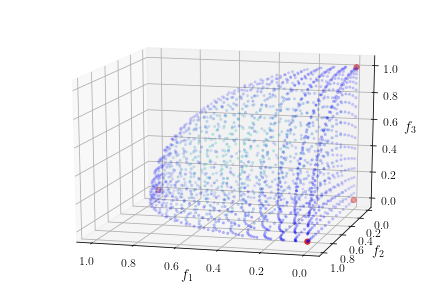

../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi
Loading depth contours from ../../data/dtlz2-nbi/5d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz2-nbi/5d/depth-cont-cvhull.csv.
name = DTLZ2_NBI
n = 999
m = 5
lb = [1.9205e-17, 4.4803e-19, 1.6191e-15, 1.5844e-17, 9.4828e-11]
ub = [1.0015e+00, 1.0001e+00, 1.0000e+00, 1.0077e+00, 1.0023e+00]
cv = Array(999).fill(0.0)
clcv = Array(999).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[3.0902e-01,9.5106e-01,1.0000e+00],[-8.0902e-01,5.8779e-01,1.0000e+00],[-8.0902e-01,-5.8779e-01,1.0000e+00],[3.0902e-01,-9.5106e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[3.0902e-01,9.5106e-01,8.0000e-01],[-8.0902e-01,5.8779e-01,8.0000e-01],[-8.0902e-01,-5.8779e-01,8.0000e-01],[3.0902e-01,-9.5106e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[3.0902e-01,9.5106e-01,6.0000e-01],[-8.0902e-01,5.8779e-01,6.0

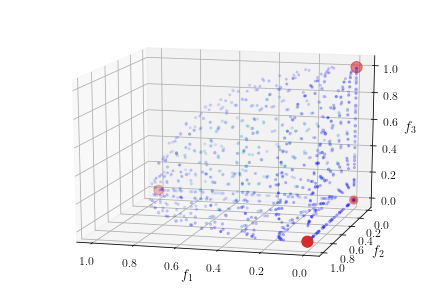

../../data/dtlz2-nbi/8d/dataf.csv (3432, 8) ['..', '..', 'data', 'dtlz2-nbi', '8d'] dtlz2-nbi
Loading depth contours from ../../data/dtlz2-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz2-nbi/8d/depth-cont-cvhull.csv.
name = DTLZ2_NBI
n = 3432
m = 8
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = Array(3432).fill(0.0)
clcv = Array(3432).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[7.0711e-01,7.0711e-01,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-7.0711e-01,7.0711e-01,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-7.0711e-01,-7.0711e-01,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[7.0711e-01,-7.0711e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[7.0711e-01,7.0711e-01,8.0000e-01],[6.1232e-17,1.0000e+00,8.0000e-01],[-7.0711e-01,7.0711e-01,

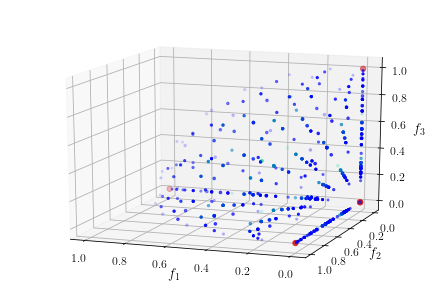

../../data/debmdk-nbi/3d/dataf.csv (1143, 3) ['..', '..', 'data', 'debmdk-nbi', '3d'] debmdk-nbi
Loading depth contours from ../../data/debmdk-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-nbi/3d/depth-cont-cvhull.csv.
name = DEBMDK_NBI
n = 1143
m = 3
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [9.5000e+00, 9.5000e+00, 9.5000e+00]
cv = Array(1143).fill(0.0)
clcv = Array(1143).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[-5.0000e-01,8.6603e-01,1.0000e+00],[-5.0000e-01,-8.6603e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[-5.0000e-01,8.6603e-01,8.0000e-01],[-5.0000e-01,-8.6603e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[-5.0000e-01,8.6603e-01,6.0000e-01],[-5.0000e-01,-8.6603e-01,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.0000e+00,0.0000e+00,4.0000e-01],[-5.0000e-01,8.6603e-01,4.0000e-01],[-5.0000e-01,-8.6603e-01,4.0000e-01],[1.0000e+00,0.0000e+00,4

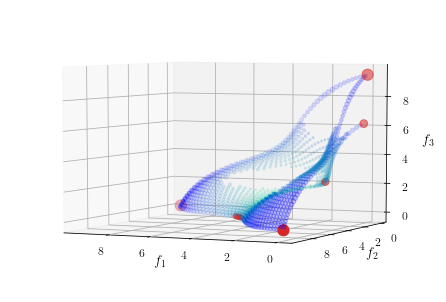

../../data/debmdk-nbi/4d/dataf.csv (2028, 4) ['..', '..', 'data', 'debmdk-nbi', '4d'] debmdk-nbi
Loading depth contours from ../../data/debmdk-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-nbi/4d/depth-cont-cvhull.csv.
name = DEBMDK_NBI
n = 2028
m = 4
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00]
cv = Array(2028).fill(0.0)
clcv = Array(2028).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[6.1232e-17,1.0000e+00,8.0000e-01],[-1.0000e+00,1.2246e-16,8.0000e-01],[-1.8370e-16,-1.0000e+00,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[6.1232e-17,1.0000e+00,6.0000e-01],[-1.0000e+00,1.2246e-16,6.0000e-01],[-1.8370e-16,-1.0000e+00,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.

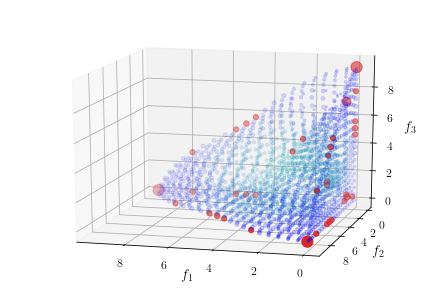

../../data/debmdk-nbi/8d/dataf.csv (3432, 8) ['..', '..', 'data', 'debmdk-nbi', '8d'] debmdk-nbi
Loading depth contours from ../../data/debmdk-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-nbi/8d/depth-cont-cvhull.csv.
name = DEBMDK_NBI
n = 3432
m = 8
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00]
cv = Array(3432).fill(0.0)
clcv = Array(3432).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[7.0711e-01,7.0711e-01,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-7.0711e-01,7.0711e-01,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-7.0711e-01,-7.0711e-01,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[7.0711e-01,-7.0711e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,7.5000e-01],[7.0711e-01,7.0711e-01,7.5000e-01],[6.1232e-17,1.0000e+00,7.5000e-01],[-7.0711e-01,7.071

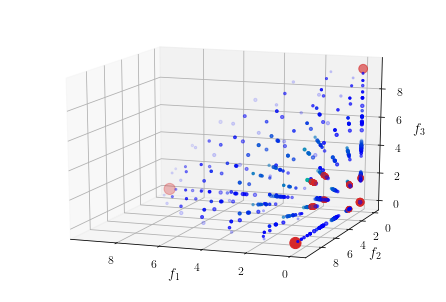

../../data/debmdk-all-nbi/3d/dataf.csv (990, 3) ['..', '..', 'data', 'debmdk-all-nbi', '3d'] debmdk-all-nbi
Loading depth contours from ../../data/debmdk-all-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-all-nbi/3d/depth-cont-cvhull.csv.
name = DEBMDK_ALL_NBI
n = 990
m = 3
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [9.5000e+00, 9.5000e+00, 9.5000e+00]
cv = Array(990).fill(0.0)
clcv = Array(990).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[-5.0000e-01,8.6603e-01,1.0000e+00],[-5.0000e-01,-8.6603e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[-5.0000e-01,8.6603e-01,8.0000e-01],[-5.0000e-01,-8.6603e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[-5.0000e-01,8.6603e-01,6.0000e-01],[-5.0000e-01,-8.6603e-01,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.0000e+00,0.0000e+00,4.0000e-01],[-5.0000e-01,8.6603e-01,4.0000e-01],[-5.0000e-01,-8.6603e-01,4.0000e-01],[1.0

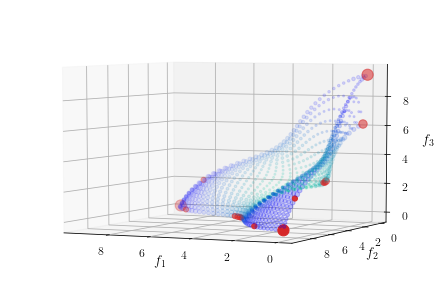

../../data/debmdk-all-nbi/4d/dataf.csv (1771, 4) ['..', '..', 'data', 'debmdk-all-nbi', '4d'] debmdk-all-nbi
Loading depth contours from ../../data/debmdk-all-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-all-nbi/4d/depth-cont-cvhull.csv.
name = DEBMDK_ALL_NBI
n = 1771
m = 4
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00]
cv = Array(1771).fill(0.0)
clcv = Array(1771).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[6.1232e-17,1.0000e+00,8.0000e-01],[-1.0000e+00,1.2246e-16,8.0000e-01],[-1.8370e-16,-1.0000e+00,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[6.1232e-17,1.0000e+00,6.0000e-01],[-1.0000e+00,1.2246e-16,6.0000e-01],[-1.8370e-16,-1.0000e+00,6.0000e-01],[1.0000e+00,0.00

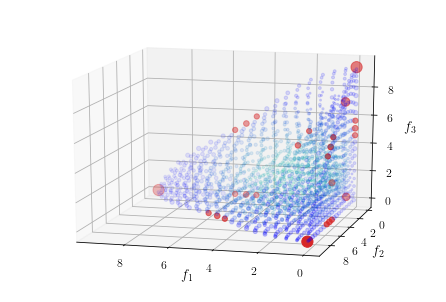

../../data/debmdk-all-nbi/8d/dataf.csv (3432, 8) ['..', '..', 'data', 'debmdk-all-nbi', '8d'] debmdk-all-nbi
Loading depth contours from ../../data/debmdk-all-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/debmdk-all-nbi/8d/depth-cont-cvhull.csv.
name = DEBMDK_ALL_NBI
n = 3432
m = 8
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00, 9.5000e+00]
cv = Array(3432).fill(0.0)
clcv = Array(3432).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[7.0711e-01,7.0711e-01,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-7.0711e-01,7.0711e-01,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-7.0711e-01,-7.0711e-01,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[7.0711e-01,-7.0711e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,7.5000e-01],[7.0711e-01,7.0711e-01,7.5000e-01],[6.1232e-17,1.0000e+00,7.5000

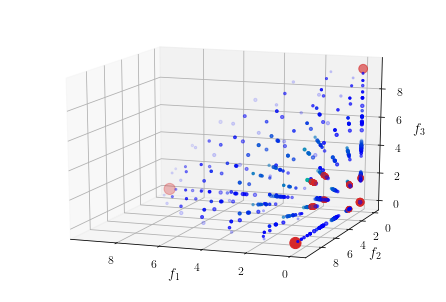

../../data/dtlz8-nbi/3d/dataf.csv (1025, 3) ['..', '..', 'data', 'dtlz8-nbi', '3d'] dtlz8-nbi
Loading depth contours from ../../data/dtlz8-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz8-nbi/3d/depth-cont-cvhull.csv.
name = DTLZ8_NBI
n = 1025
m = 3
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [6.6346e-01, 6.6346e-01, 1.0000e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[-5.0000e-01,8.6603e-01,1.0000e+00],[-5.0000e-01,-8.6603e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[-5.0000e-01,8.6603e-01,8.0000e-01],[-5.0000e-01,-8.6603e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[-5.0000e-01,8.6603e-01,6.0000e-01],[-5.0000e-01,-8.6603e-01,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.0000e+00,0.0000e+00,4.0000e-01],[-5.0000e-01,8.6603e-01,4.0000e-01],[-5.0000e-01,-8.6603e-01,4.0000e-01],[1.0000e+00,0.0000e+00,4.

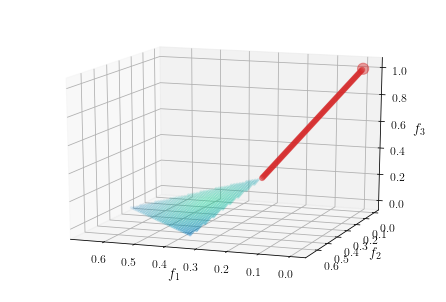

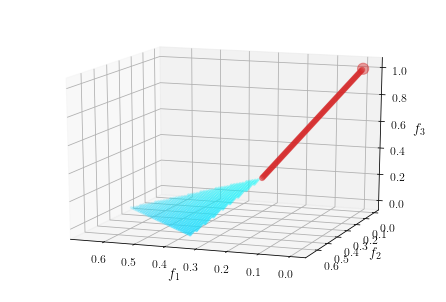

../../data/dtlz8-nbi/4d/dataf.csv (2088, 4) ['..', '..', 'data', 'dtlz8-nbi', '4d'] dtlz8-nbi
Loading depth contours from ../../data/dtlz8-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz8-nbi/4d/depth-cont-cvhull.csv.
name = DTLZ8_NBI
n = 2088
m = 4
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, -1.3953e-01]
ub = [6.7442e-01, 6.7442e-01, 6.7442e-01, 1.0000e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[6.1232e-17,1.0000e+00,8.0000e-01],[-1.0000e+00,1.2246e-16,8.0000e-01],[-1.8370e-16,-1.0000e+00,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[6.1232e-17,1.0000e+00,6.0000e-01],[-1.0000e+00,1.2246e-16,6.0000e-01],[-1.8370e-16,-1.0000e+00,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.

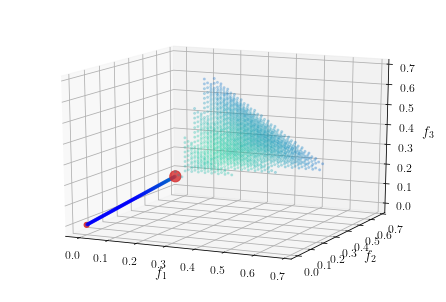

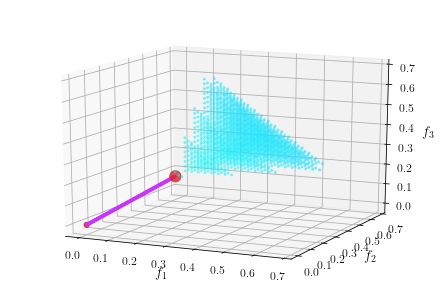

../../data/dtlz8-nbi/6d/dataf.csv (3535, 6) ['..', '..', 'data', 'dtlz8-nbi', '6d'] dtlz8-nbi
Loading depth contours from ../../data/dtlz8-nbi/6d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz8-nbi/6d/depth-cont-cvhull.csv.
name = DTLZ8_NBI
n = 3535
m = 6
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, -6.6667e-01]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[5.0000e-01,8.6603e-01,1.0000e+00],[-5.0000e-01,8.6603e-01,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-5.0000e-01,-8.6603e-01,1.0000e+00],[5.0000e-01,-8.6603e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[5.0000e-01,8.6603e-01,8.0000e-01],[-5.0000e-01,8.6603e-01,8.0000e-01],[-1.0000e+00,1.2246e-16,8.0000e-01],[-5.0000e-01,-8.6603e-01,8.0000e-01],[5.0000e-01,-8.6603e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.000

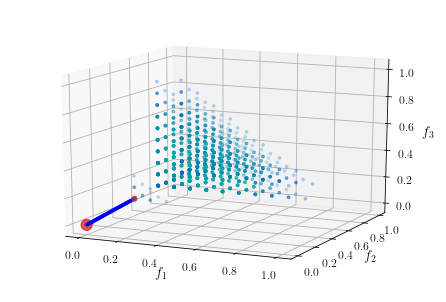

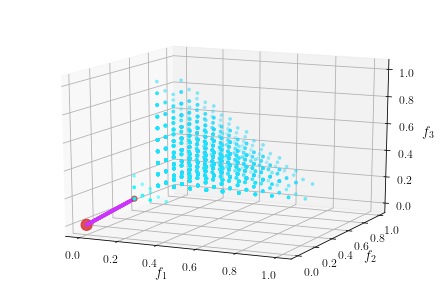

../../data/dtlz8-nbi/8d/dataf.csv (2277, 8) ['..', '..', 'data', 'dtlz8-nbi', '8d'] dtlz8-nbi
Loading depth contours from ../../data/dtlz8-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/dtlz8-nbi/8d/depth-cont-cvhull.csv.
name = DTLZ8_NBI
n = 2277
m = 8
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, -1.5000e+00]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[7.0711e-01,7.0711e-01,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-7.0711e-01,7.0711e-01,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-7.0711e-01,-7.0711e-01,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[7.0711e-01,-7.0711e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[7.0711e-01,7.0711e-01,8.0000e-01],[6.1232e-17,1.0000e+00,8.0000e-01],[-7.0711e-01,7.071

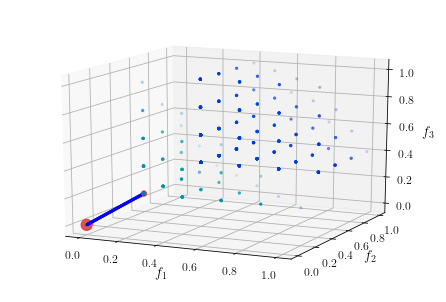

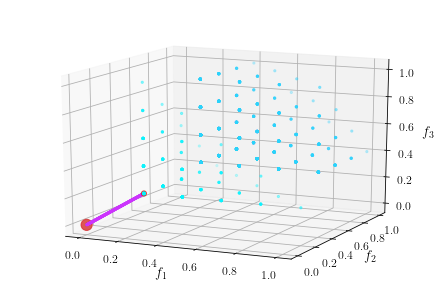

../../data/c2dtlz2-nbi/3d/dataf.csv (1036, 3) ['..', '..', 'data', 'c2dtlz2-nbi', '3d'] c2dtlz2-nbi
Loading depth contours from ../../data/c2dtlz2-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c2dtlz2-nbi/3d/depth-cont-cvhull.csv.
name = C2DTLZ2_NBI
n = 1036
m = 3
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[-5.0000e-01,8.6603e-01,1.0000e+00],[-5.0000e-01,-8.6603e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[-5.0000e-01,8.6603e-01,8.0000e-01],[-5.0000e-01,-8.6603e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[-5.0000e-01,8.6603e-01,6.0000e-01],[-5.0000e-01,-8.6603e-01,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.0000e+00,0.0000e+00,4.0000e-01],[-5.0000e-01,8.6603e-01,4.0000e-01],[-5.0000e-01,-8.6603e-01,4.0000e-01],[1.0000e+00,0

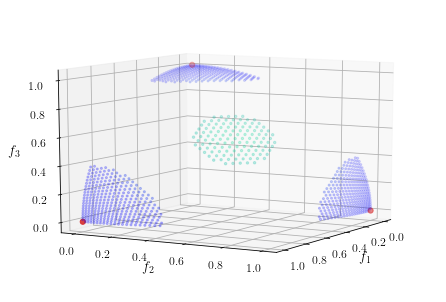

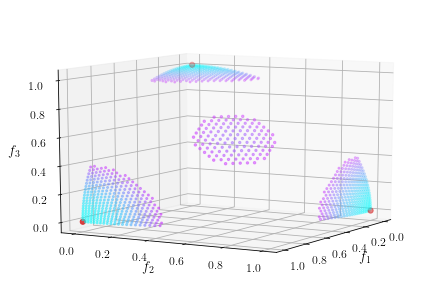

../../data/c2dtlz2-nbi/4d/dataf.csv (1984, 4) ['..', '..', 'data', 'c2dtlz2-nbi', '4d'] c2dtlz2-nbi
Loading depth contours from ../../data/c2dtlz2-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c2dtlz2-nbi/4d/depth-cont-cvhull.csv.
name = C2DTLZ2_NBI
n = 1984
m = 4
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[6.1232e-17,1.0000e+00,8.0000e-01],[-1.0000e+00,1.2246e-16,8.0000e-01],[-1.8370e-16,-1.0000e+00,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[6.1232e-17,1.0000e+00,6.0000e-01],[-1.0000e+00,1.2246e-16,6.0000e-01],[-1.8370e-16,-1.0000e+00,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000

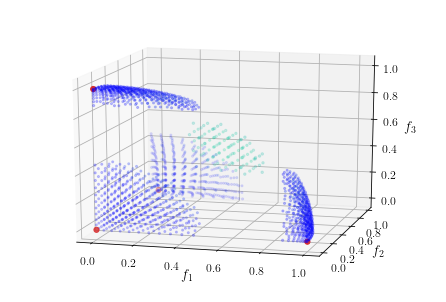

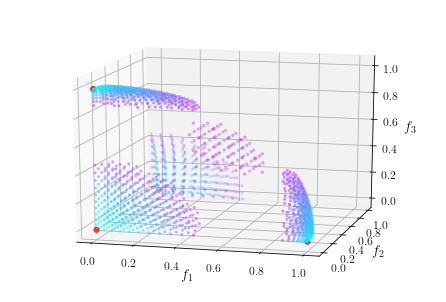

../../data/c2dtlz2-nbi/5d/dataf.csv (2280, 5) ['..', '..', 'data', 'c2dtlz2-nbi', '5d'] c2dtlz2-nbi
Loading depth contours from ../../data/c2dtlz2-nbi/5d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c2dtlz2-nbi/5d/depth-cont-cvhull.csv.
name = C2DTLZ2_NBI
n = 2280
m = 5
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[3.0902e-01,9.5106e-01,1.0000e+00],[-8.0902e-01,5.8779e-01,1.0000e+00],[-8.0902e-01,-5.8779e-01,1.0000e+00],[3.0902e-01,-9.5106e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,7.5000e-01],[3.0902e-01,9.5106e-01,7.5000e-01],[-8.0902e-01,5.8779e-01,7.5000e-01],[-8.0902e-01,-5.8779e-01,7.5000e-01],[3.0902e-01,-9.5106e-01,7.5000e-01],[1.0000e+00,0.0000e+00,7.5000e-01]],[[1.0000e+00,0.0000e+00,5.0000e-01],[3.0902e-01,9.5106e-01,5.0000e-01],[-8.09

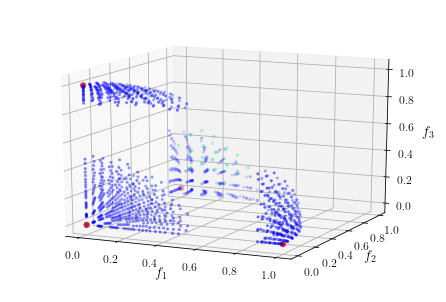

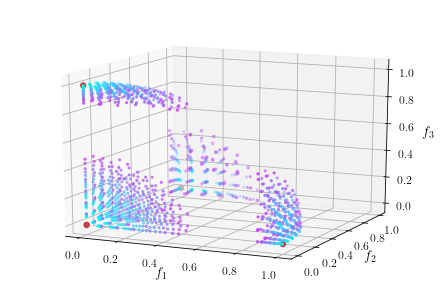

../../data/c2dtlz2-nbi/8d/dataf.csv (3872, 8) ['..', '..', 'data', 'c2dtlz2-nbi', '8d'] c2dtlz2-nbi
Loading depth contours from ../../data/c2dtlz2-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c2dtlz2-nbi/8d/depth-cont-cvhull.csv.
name = C2DTLZ2_NBI
n = 3872
m = 8
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[7.0711e-01,7.0711e-01,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-7.0711e-01,7.0711e-01,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-7.0711e-01,-7.0711e-01,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[7.0711e-01,-7.0711e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[7.0711e-01,7.0711e-01,8.0000e-01],[6.1232e-17,1.0000e+00,8.0000e-01],[-7.071

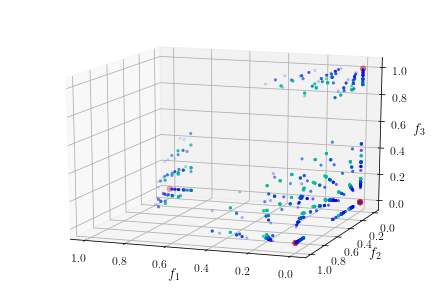

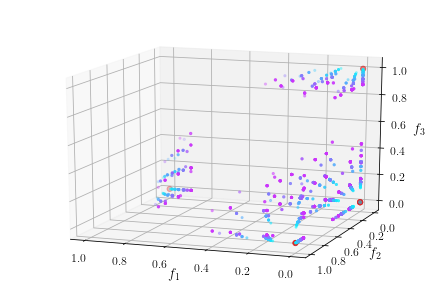

../../data/cdebmdk-nbi/3d/dataf.csv (1049, 3) ['..', '..', 'data', 'cdebmdk-nbi', '3d'] cdebmdk-nbi
Loading depth contours from ../../data/cdebmdk-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/cdebmdk-nbi/3d/depth-cont-cvhull.csv.
name = CDEBMDK_NBI
n = 1049
m = 3
lb = [1.0978e+00, 1.0978e+00, 1.6772e+00]
ub = [3.0220e+00, 3.0220e+00, 3.4412e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[-5.0000e-01,8.6603e-01,1.0000e+00],[-5.0000e-01,-8.6603e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[-5.0000e-01,8.6603e-01,8.0000e-01],[-5.0000e-01,-8.6603e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[-5.0000e-01,8.6603e-01,6.0000e-01],[-5.0000e-01,-8.6603e-01,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.0000e+00,0.0000e+00,4.0000e-01],[-5.0000e-01,8.6603e-01,4.0000e-01],[-5.0000e-01,-8.6603e-01,4.0000e-01],[1.0000e+00,0

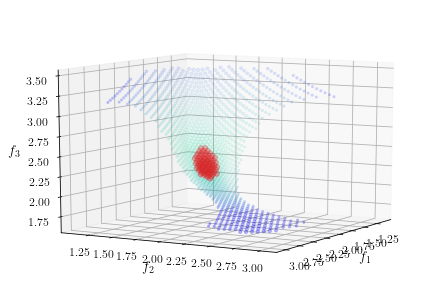

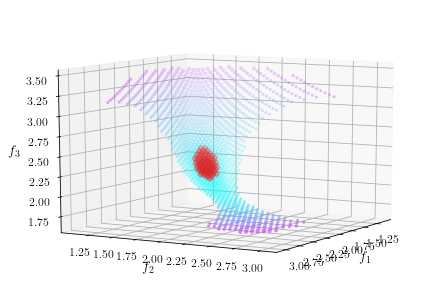

../../data/cdebmdk-nbi/4d/dataf.csv (2042, 4) ['..', '..', 'data', 'cdebmdk-nbi', '4d'] cdebmdk-nbi
Loading depth contours from ../../data/cdebmdk-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/cdebmdk-nbi/4d/depth-cont-cvhull.csv.
name = CDEBMDK_NBI
n = 2042
m = 4
lb = [6.3913e-01, 6.3913e-01, 8.2605e-01, 1.2069e+00]
ub = [2.9859e+00, 2.9859e+00, 3.0829e+00, 3.2705e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[6.1232e-17,1.0000e+00,8.0000e-01],[-1.0000e+00,1.2246e-16,8.0000e-01],[-1.8370e-16,-1.0000e+00,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[6.1232e-17,1.0000e+00,6.0000e-01],[-1.0000e+00,1.2246e-16,6.0000e-01],[-1.8370e-16,-1.0000e+00,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000

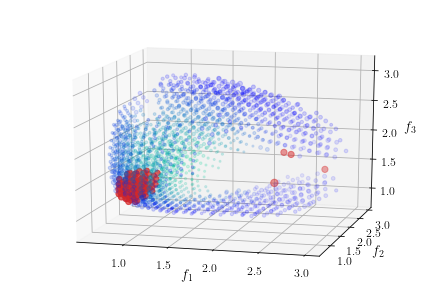

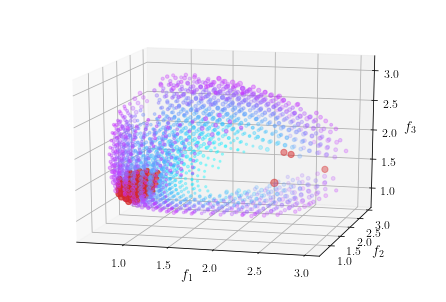

../../data/cdebmdk-nbi/8d/dataf.csv (3380, 8) ['..', '..', 'data', 'cdebmdk-nbi', '8d'] cdebmdk-nbi
Loading depth contours from ../../data/cdebmdk-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/cdebmdk-nbi/8d/depth-cont-cvhull.csv.
name = CDEBMDK_NBI
n = 3380
m = 8
lb = [4.5011e-01, 4.5011e-01, 4.7868e-01, 4.8801e-01, 4.9205e-01, 4.9432e-01, 4.9723e-01, 5.3767e-01]
ub = [3.2677e+00, 3.2677e+00, 3.0550e+00, 3.0345e+00, 3.0269e+00, 2.9755e+00, 2.9314e+00, 3.1556e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[7.0711e-01,7.0711e-01,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-7.0711e-01,7.0711e-01,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-7.0711e-01,-7.0711e-01,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[7.0711e-01,-7.0711e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[7.0711e-01,7.0711e-01,8.0000e-01],[6.1232e-17,1.0000e+00,8.0000e-01],[-7.071

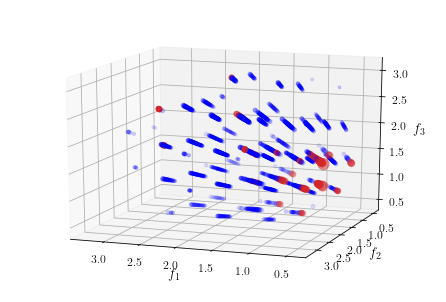

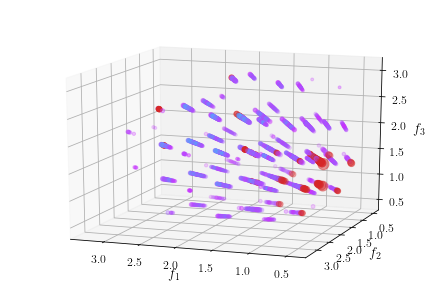

../../data/c0dtlz2-nbi/3d/dataf.csv (983, 3) ['..', '..', 'data', 'c0dtlz2-nbi', '3d'] c0dtlz2-nbi
Loading depth contours from ../../data/c0dtlz2-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c0dtlz2-nbi/3d/depth-cont-cvhull.csv.
name = C0DTLZ2_NBI
n = 983
m = 3
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[-5.0000e-01,8.6603e-01,1.0000e+00],[-5.0000e-01,-8.6603e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[-5.0000e-01,8.6603e-01,8.0000e-01],[-5.0000e-01,-8.6603e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[-5.0000e-01,8.6603e-01,6.0000e-01],[-5.0000e-01,-8.6603e-01,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.0000e+00,0.0000e+00,4.0000e-01],[-5.0000e-01,8.6603e-01,4.0000e-01],[-5.0000e-01,-8.6603e-01,4.0000e-01],[1.0000e+00,0.0

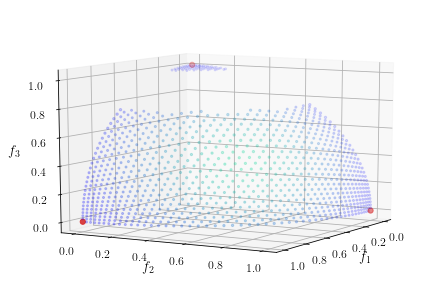

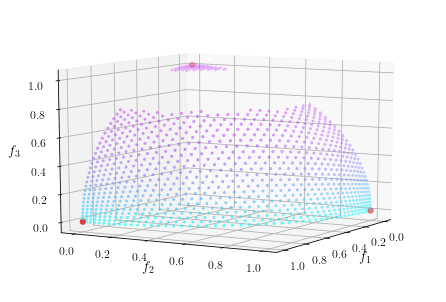

../../data/c0dtlz2-nbi/4d/dataf.csv (1916, 4) ['..', '..', 'data', 'c0dtlz2-nbi', '4d'] c0dtlz2-nbi
Loading depth contours from ../../data/c0dtlz2-nbi/4d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c0dtlz2-nbi/4d/depth-cont-cvhull.csv.
name = C0DTLZ2_NBI
n = 1916
m = 4
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[6.1232e-17,1.0000e+00,8.0000e-01],[-1.0000e+00,1.2246e-16,8.0000e-01],[-1.8370e-16,-1.0000e+00,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[6.1232e-17,1.0000e+00,6.0000e-01],[-1.0000e+00,1.2246e-16,6.0000e-01],[-1.8370e-16,-1.0000e+00,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000

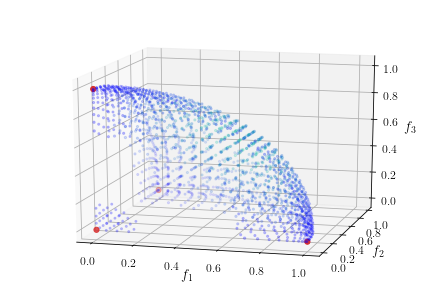

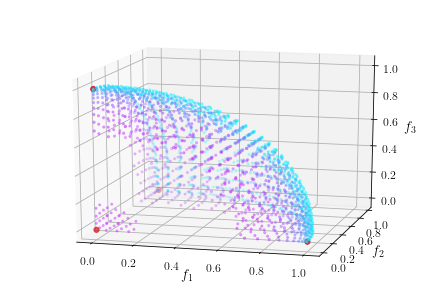

../../data/c0dtlz2-nbi/8d/dataf.csv (3180, 8) ['..', '..', 'data', 'c0dtlz2-nbi', '8d'] c0dtlz2-nbi
Loading depth contours from ../../data/c0dtlz2-nbi/8d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/c0dtlz2-nbi/8d/depth-cont-cvhull.csv.
name = C0DTLZ2_NBI
n = 3180
m = 8
lb = [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]
ub = [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[7.0711e-01,7.0711e-01,1.0000e+00],[6.1232e-17,1.0000e+00,1.0000e+00],[-7.0711e-01,7.0711e-01,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-7.0711e-01,-7.0711e-01,1.0000e+00],[-1.8370e-16,-1.0000e+00,1.0000e+00],[7.0711e-01,-7.0711e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,7.5000e-01],[7.0711e-01,7.0711e-01,7.5000e-01],[6.1232e-17,1.0000e+00,7.5000e-01],[-7.071

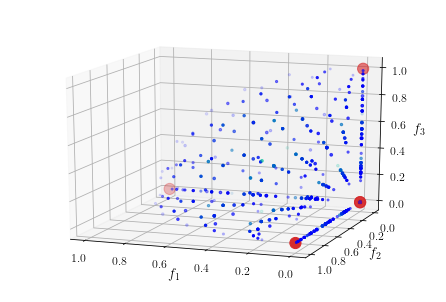

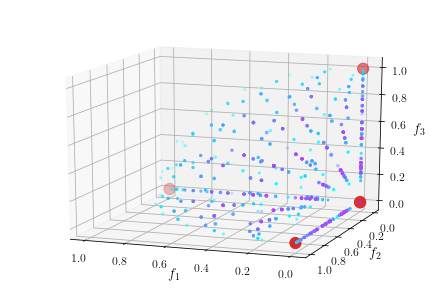

../../data/crash-nbi/3d/dataf.csv (4450, 3) ['..', '..', 'data', 'crash-nbi', '3d'] crash-nbi
Loading depth contours from ../../data/crash-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/crash-nbi/3d/depth-cont-cvhull.csv.
name = CRASH_NBI
n = 4450
m = 3
lb = [1.6617e+03, 6.1428e+00, 3.0424e-02]
ub = [1.6942e+03, 1.0591e+01, 2.3160e-01]
cv = Array(4450).fill(0.0)
clcv = Array(4450).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[-5.0000e-01,8.6603e-01,1.0000e+00],[-5.0000e-01,-8.6603e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[-5.0000e-01,8.6603e-01,8.0000e-01],[-5.0000e-01,-8.6603e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[-5.0000e-01,8.6603e-01,6.0000e-01],[-5.0000e-01,-8.6603e-01,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.0000e+00,0.0000e+00,4.0000e-01],[-5.0000e-01,8.6603e-01,4.0000e-01],[-5.0000e-01,-8.6603e-01,4.0000e-01],[1.0000e+00,0.0000e+00,4.0000e

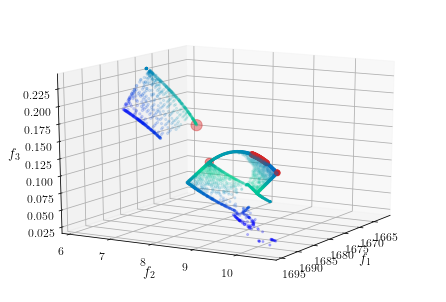

../../data/crash-c1-nbi/3d/dataf.csv (711, 3) ['..', '..', 'data', 'crash-c1-nbi', '3d'] crash-c1-nbi
Loading depth contours from ../../data/crash-c1-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/crash-c1-nbi/3d/depth-cont-cvhull.csv.
name = CRASH_C1_NBI
n = 711
m = 3
lb = [1.6702e+03, 6.1428e+00, 1.3932e-01]
ub = [1.6844e+03, 6.9448e+00, 2.3160e-01]
cv = Array(711).fill(0.0)
clcv = Array(711).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[-5.0000e-01,8.6603e-01,1.0000e+00],[-5.0000e-01,-8.6603e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[-5.0000e-01,8.6603e-01,8.0000e-01],[-5.0000e-01,-8.6603e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[-5.0000e-01,8.6603e-01,6.0000e-01],[-5.0000e-01,-8.6603e-01,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.0000e+00,0.0000e+00,4.0000e-01],[-5.0000e-01,8.6603e-01,4.0000e-01],[-5.0000e-01,-8.6603e-01,4.0000e-01],[1.0000e+00,0.00

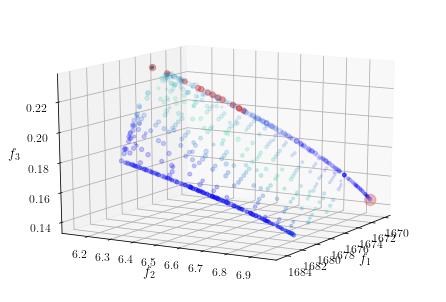

../../data/crash-c2-nbi/3d/dataf.csv (3739, 3) ['..', '..', 'data', 'crash-c2-nbi', '3d'] crash-c2-nbi
Loading depth contours from ../../data/crash-c2-nbi/3d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/crash-c2-nbi/3d/depth-cont-cvhull.csv.
name = CRASH_C2_NBI
n = 3739
m = 3
lb = [1.6617e+03, 6.9448e+00, 3.0424e-02]
ub = [1.6942e+03, 1.0591e+01, 9.9153e-02]
cv = Array(3739).fill(0.0)
clcv = Array(3739).fill("grey")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[-5.0000e-01,8.6603e-01,1.0000e+00],[-5.0000e-01,-8.6603e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0000e+00,0.0000e+00,8.0000e-01],[-5.0000e-01,8.6603e-01,8.0000e-01],[-5.0000e-01,-8.6603e-01,8.0000e-01],[1.0000e+00,0.0000e+00,8.0000e-01]],[[1.0000e+00,0.0000e+00,6.0000e-01],[-5.0000e-01,8.6603e-01,6.0000e-01],[-5.0000e-01,-8.6603e-01,6.0000e-01],[1.0000e+00,0.0000e+00,6.0000e-01]],[[1.0000e+00,0.0000e+00,4.0000e-01],[-5.0000e-01,8.6603e-01,4.0000e-01],[-5.0000e-01,-8.6603e-01,4.0000e-01],[1.0000e+00,

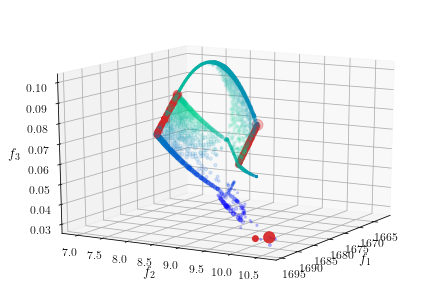

../../data/gaa-nbi/10d/dataf.csv (3112, 10) ['..', '..', 'data', 'gaa-nbi', '10d'] gaa-nbi
Loading depth contours from ../../data/gaa-nbi/10d/depth-cont-cvhull.csv.
Loading depth contours from ../../data/gaa-nbi/10d/depth-cont-cvhull.csv.
name = GAA_NBI
n = 3112
m = 10
lb = [7.3290e+01, 1.8814e+03, 5.7628e+01, 1.8247e+00, 3.6679e+02, 4.2016e+04, -2.5247e+03, -1.6678e+01, -2.0266e+02, 1.1078e-07]
ub = [7.4301e+01, 2.0192e+03, 8.2532e+01, 2.0022e+00, 5.0000e+02, 4.4696e+04, -1.9984e+03, -1.4388e+01, -1.8628e+02, 3.6910e+00]
cv = require("./datacv.json")
clcv = require("./color-cv.json")
apv = [[[1.0000e+00,0.0000e+00,1.0000e+00],[8.0902e-01,5.8779e-01,1.0000e+00],[3.0902e-01,9.5106e-01,1.0000e+00],[-3.0902e-01,9.5106e-01,1.0000e+00],[-8.0902e-01,5.8779e-01,1.0000e+00],[-1.0000e+00,1.2246e-16,1.0000e+00],[-8.0902e-01,-5.8779e-01,1.0000e+00],[-3.0902e-01,-9.5106e-01,1.0000e+00],[3.0902e-01,-9.5106e-01,1.0000e+00],[8.0902e-01,-5.8779e-01,1.0000e+00],[1.0000e+00,0.0000e+00,1.0000e+00]],[[1.0

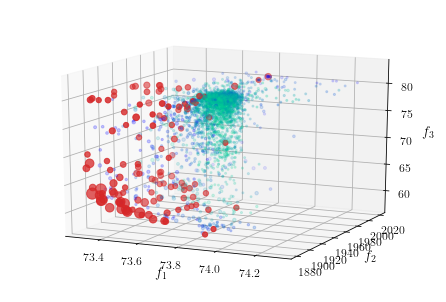

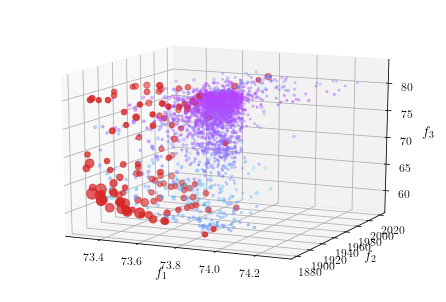

In [3]:
%matplotlib inline
sys.path.append('../../')
import pathlib
from vis.plotting import scatter
from vis.plotting.scatter import camera_angles
from vis.plotting.paletteviz import get_palette_radviz_coordinates, get_palette_star_coordinates
from vis.plotting.radviz import get_radviz_coordinates
from vis.plotting.star import get_star_coordinates


pfs = {'dtlz2': ['3d', '4d', '8d'], \
       'debmdk': ['3d', '4d', '8d'], \
       'debmdk-all': ['3d', '4d', '8d'], \
       'dtlz8': ['3d', '4d', '6d', '8d'], \
       'c2dtlz2': ['3d', '4d', '5d', '8d'], \
       'cdebmdk': ['3d', '4d', '8d'], \
       'c0dtlz2': ['3d', '4d', '8d'], \
       'gaa': ['10d']}

pfs_nbi = {
    'dtlz2-nbi': ['3d', '4d', '5d', '8d'], \
    'debmdk-nbi': ['3d', '4d', '8d'], \
    'debmdk-all-nbi': ['3d', '4d', '8d'], \
    'dtlz8-nbi': ['3d', '4d', '6d', '8d'], \
    'c2dtlz2-nbi': ['3d', '4d', '5d', '8d'], \
    'cdebmdk-nbi': ['3d', '4d', '8d'], \
    'c0dtlz2-nbi': ['3d', '4d', '8d'], \
    'crash-nbi': ['3d'], 'crash-c1-nbi': ['3d'], 'crash-c2-nbi': ['3d'], \
    'gaa-nbi': ['10d']}

constrained_pfs = ['dtlz8', 'dtlz8-nbi', 'c2dtlz2', 'c2dtlz2-nbi', 'cdebmdk', 'cdebmdk-nbi', \
                   'c0dtlz2', 'c0dtlz2-nbi', 'gaa', 'gaa-nbi']

for pf in list(pfs_nbi.keys()):
    for dim in pfs_nbi[pf]:
        fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
        destpath = "./data/{0:s}/{1:s}".format(pf, dim)
        pathlib.Path(destpath).mkdir(parents=True, exist_ok=True)
        if os.path.exists(fullpathf):
            path, filenamef = os.path.split(fullpathf)
            dirs = path.split('/')
            frontname = dirs[-2]

            # load the front
            F = np.loadtxt(fullpathf, delimiter=',')
            print(fullpathf, F.shape, dirs, frontname)

            # decide color and size
            CV, Mu, Ik = load_props(path)
            S,Cd,Ccv,D = decide_size_color(CV, Mu, Ik)
            
            # get the depth contour path
            depth_contour_path = os.path.join(path, "depth-cont-cvhull.csv")
            if os.path.exists(depth_contour_path):
                PRV = get_palette_radviz_coordinates(F, depth_contours=depth_contour_path, \
                                                          n_partitions=5, verbose=True)
                PSV = get_palette_star_coordinates(F, depth_contours=depth_contour_path, \
                                                          n_partitions=5, verbose=True)
            # get the radviz and star coordinates
            FRV = get_radviz_coordinates(F)
            FSV = get_star_coordinates(F)

            # now generate index.js file
            dump_files(destpath, PFD=[F, Mu, Ik], CDD=[D, Cd], CVD=[CV, Ccv], \
                       PRV=PRV, PSV=PSV, FRV=FRV, FSV=FSV)

            with plt.rc_context({"text.usetex": True, "font.size": 12}):
                # plot
                scatter.plot(F, ax=Axes3D(plt.figure()), s=S, c=Cd, euler=camera_angles[pf][dim])
                if Ccv is not None:
                    scatter.plot(F, ax=Axes3D(plt.figure()), s=S, c=Ccv, euler=camera_angles[pf][dim])
                # show
                plt.show()